# 聚类--实例操作

In [2]:
import pandas as pd
from sklearn.decomposition import PCA  # 主成分分析--用于较少特征数
from sklearn.cluster import KMeans  # KMeans聚类算法
import matplotlib.pyplot as plt  # 轮廓系数,用于判定聚类的效果
from sklearn.metrics import silhouette_score

In [4]:
# 读取数据
# 订单与产品信息关联表
prior = pd.read_csv('./data/instacart/order_products__prior.csv')
# 产品数据表
product = pd.read_csv('./data/instacart/products.csv')
# 订单信息表
order = pd.read_csv('./data/instacart/orders.csv')
# 超市过道信息表
aisles = pd.read_csv('./data/instacart/aisles.csv')

In [5]:
# 查看每张表的数据结构
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
# 通过merge连接操作将四张表合为一个数据集
_mg = pd.merge(prior, product, on=['product_id', 'product_id'])
_mg = pd.merge(_mg, order, on=['order_id', 'order_id'])
mt = pd.merge(_mg, aisles, on=['aisle_id', 'aisle_id'])

In [10]:
# 查看连接后的数据及数据规模
mt.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs


In [12]:
mt.shape

(32434489, 14)

In [14]:
# 交叉表（特殊的分组工具），如果在这一步内存不够了，重启一下jupyter
# 通过交叉表提取出走廊与用户id分别作为行与列,得到每个用户到达各走廊的情况
cross = pd.crosstab(mt['user_id'], mt['aisle'])
# 查看交叉结果
cross.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [15]:
cross.shape

(206209, 134)

In [16]:
# 通过观察交叉表的结构,发现有134个过道,其中难免包括许多客户不怎么去的
# 因此有必要进行特征分析,去掉一部分对结果影响不大的特征
pca = PCA(n_components=0.9)

data = pca.fit_transform(cross)
data.shape

(206209, 27)

In [ ]:
'''
观察pca分析后的数据,发现特征数从134变为27
可以看出,pca中所传入的参数,并不是说严格的按照得到原数据的90%取进行特征分析
'''

In [17]:
# 进一步缩小样本数,便于处理分析
x = data[:2000]
print(type(x))
x.shape

<class 'numpy.ndarray'>


(2000, 27)

In [18]:
# 利用Kmeans开始进行聚类分析
# 指定类别数开始训练
km = KMeans(n_clusters=4)

# 开始训练
km.fit(x)  # 聚类算法中没有所谓训练集与测试集

# 开始预测
predict = km.predict(x)
# 得到的是预测后每一个样本的类别
predict

array([3, 3, 3, ..., 3, 3, 3])

In [19]:
len(predict)

2000

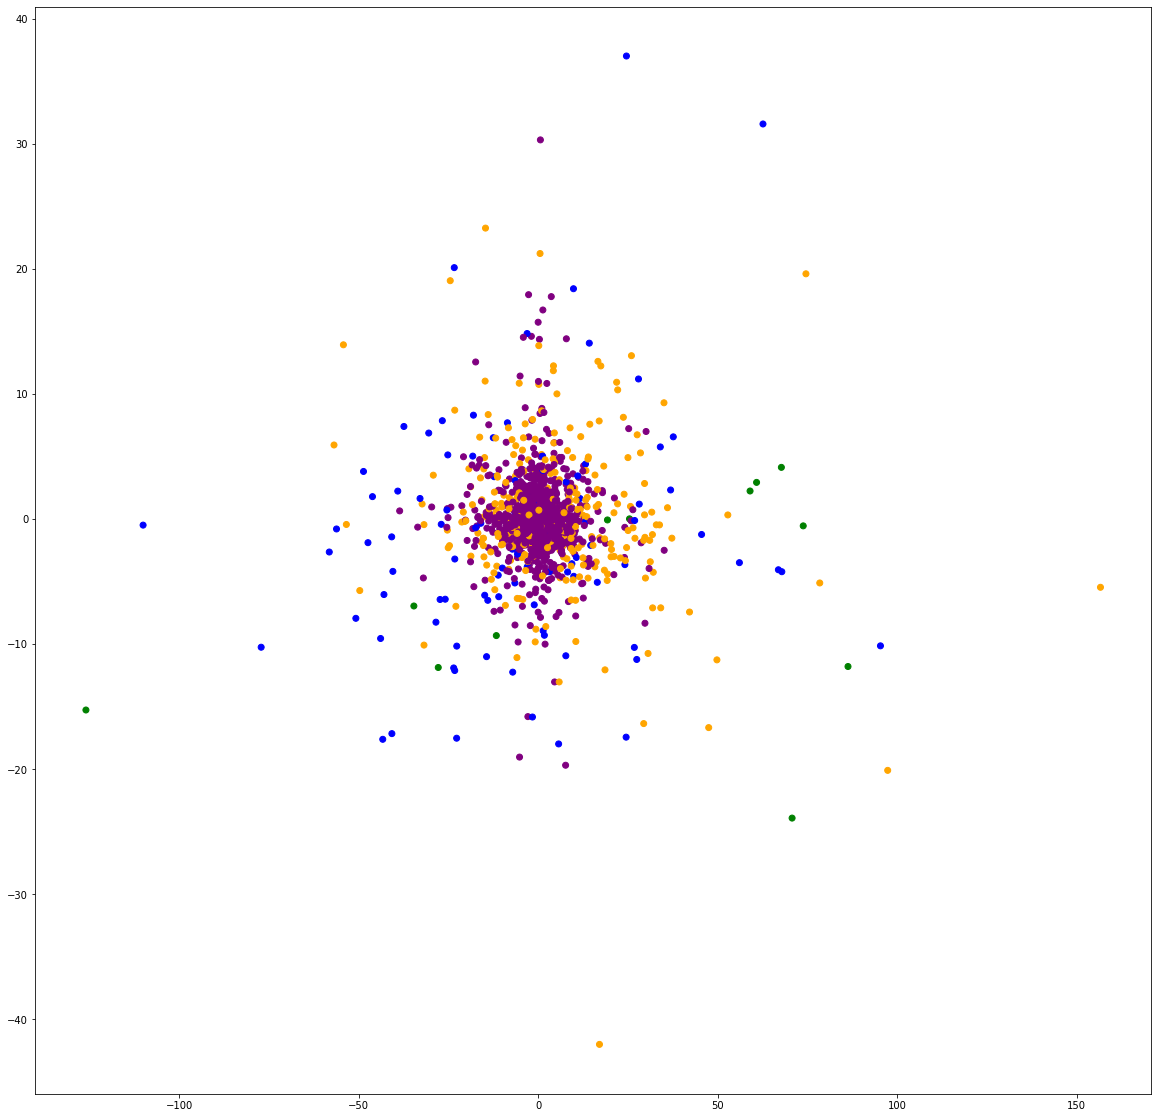

In [21]:
# 通过作图观察预测的结果
plt.figure(figsize=(20, 20))

# 建议四个不同的颜色来显示不同的类别
colored = ['orange', 'green', 'blue', 'purple']
colr = [colored[i] for i in predict]
#取任意两个特征来看聚类的图--散点图,通过颜色来判别类别
plt.scatter(x[:, 2], x[:, 20], color=colr)

In [22]:
# 通过轮廓系数评判聚类效果
silhouette_score(x, predict)

0.5067596253754605

In [ ]:
# 根据轮廓系数来进一步调整Kmeans中的类别数

In [24]:
#改为2时的结果
km = KMeans(n_clusters=3)
km.fit(x)  #开始训练
predict = km.predict(x)
silhouette_score(x, predict)

0.617762018194204

In [25]:
#改为2时的结果
km = KMeans(n_clusters=2)
km.fit(x)  #开始训练
predict = km.predict(x)
silhouette_score(x, predict)


0.7047774300085493

通过轮廓系数的分析,显然分为两种类别情况下数据更加合理

In [ ]:
# 画图观察一下两个类别时

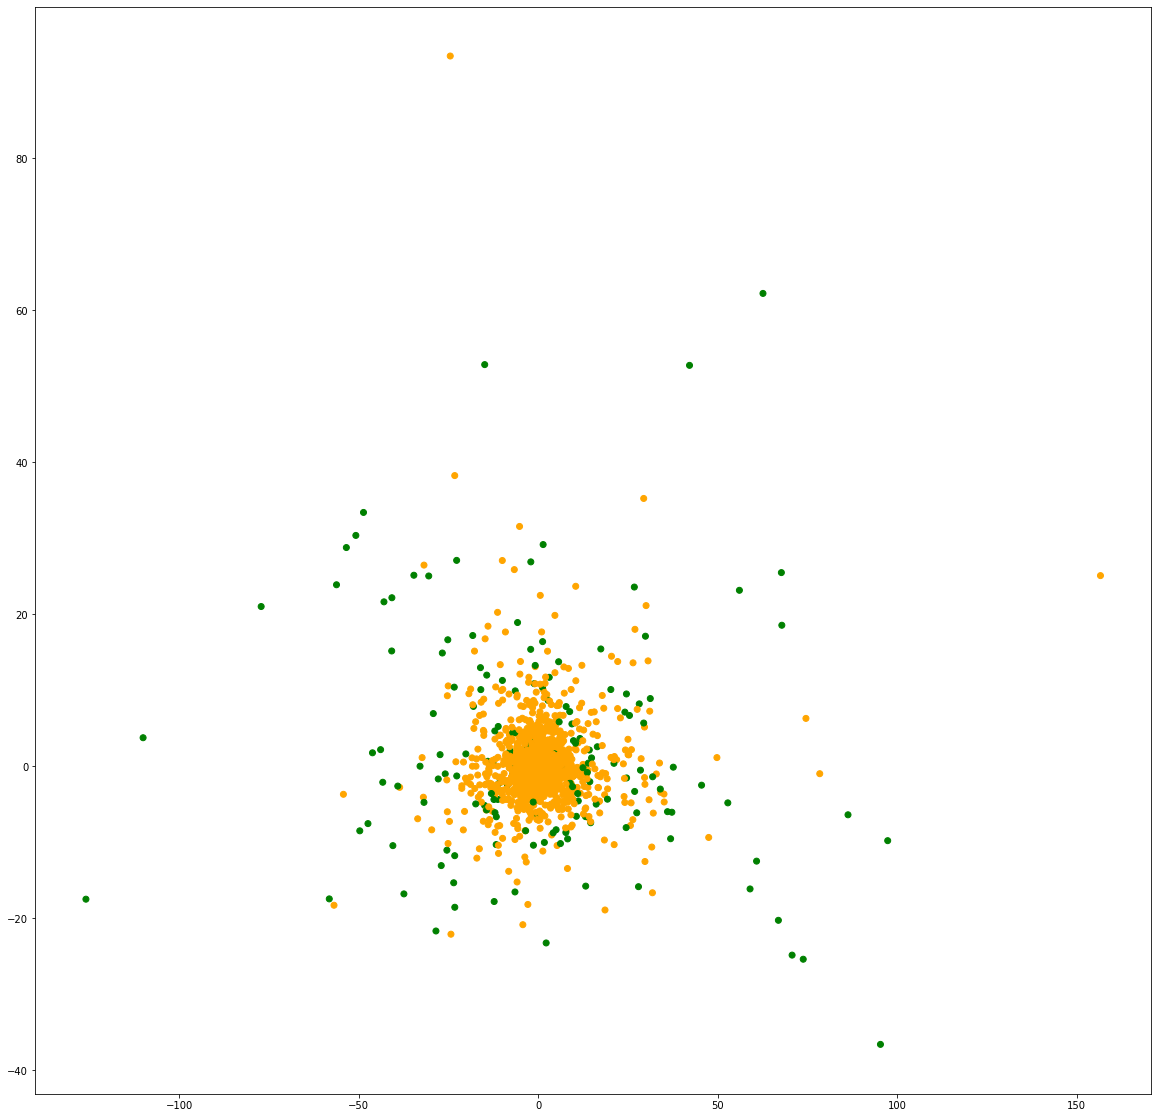

In [27]:
# 通过作图观察预测的结果
plt.figure(figsize=(20, 20))

# 建议四个不同的颜色来显示不同的类别
colored = ['orange', 'green']
colr = [colored[i] for i in predict]
#取任意两个特征来看聚类的图--散点图,通过颜色来判别类别
plt.scatter(x[:, 2], x[:, 10], color=colr)

图里可以看到第一种类的分类效果还是比较好的

# 集成学习

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

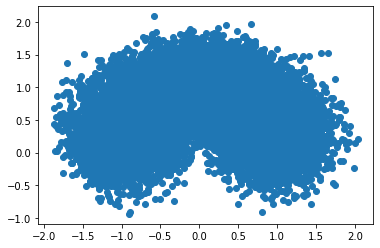

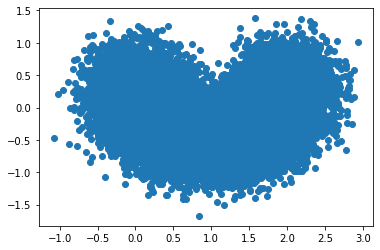

In [30]:
# 利用上sklearn的datasets随机生成得到数据集
# n_samples指定样本数,noise指定数据集中的干扰数据占比
x, y = datasets.make_moons(n_samples=50000, noise=0.3, random_state=42)
# 单独打印查看
plt.scatter(x[y == 0, 0], x[y == 0, 1])  #拿到特征中标签为0的第0列，拿到标签为0的第一列
plt.show()
plt.scatter(x[y == 1, 0], x[y == 1, 1]) #拿到特征中标签为1的第0列，拿到标签为1的第一列
plt.show()

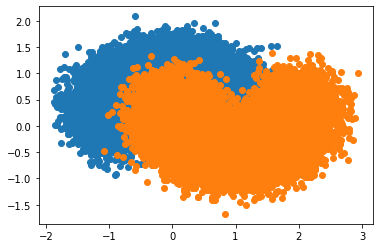

In [31]:
# 合并打印查看
plt.scatter(x[y == 0, 0], x[y == 0, 1])  #拿到特征中标签为0的第0列，拿到标签为0的第一列
plt.scatter(x[y == 1, 0], x[y == 1, 1]) #拿到特征中标签为1的第0列，拿到标签为1的第一列
plt.show()

In [36]:
# 查看数据
print(x[y==0,0])
print('-'*50)
print(x[y==0])
print(x[y==0].shape)
print('-'*50)
print(x.shape)

[ 0.11096372  0.61562814  0.46175947 ...  0.27571831  0.90929791
 -0.97512015]
--------------------------------------------------
[[ 0.11096372  1.10964541]
 [ 0.61562814 -0.06539887]
 [ 0.46175947  1.17926518]
 ...
 [ 0.27571831  1.03299749]
 [ 0.90929791 -0.09962261]
 [-0.97512015  0.87195198]]
(25000, 2)
--------------------------------------------------
(50000, 2)


array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

观察数据可以发现,x为数据集,y为数据集中的标签,共有两个标签,为0或1

In [37]:
#默认分割比例是75%和25%
from sklearn.model_selection import train_test_split # 数据分割

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

### 观察不同算法下的预测效果
然后手动模拟不同算法预测后进行加权的硬性投票并行集成学习

逻辑回归预测

In [38]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()
log_clf.fit(x_train, y_train)
log_clf.score(x_test, y_test)

0.85336

SVC向量机预测

In [39]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_clf.score(x_test, y_test)

0.91216

决策树算法预测

In [40]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
dt_clf.score(x_test, y_test)

0.87576

In [41]:
# 并行集成学习模拟--硬性投票
#训练好模型，测试集做预测
y_predict1 = log_clf.predict(x_test)
y_predict2 = svm_clf.predict(x_test)
y_predict3 = dt_clf.predict(x_test)
#手动模拟集成学习bagging,硬voteing算法模式,不考虑权值概率等
y_predict = np.array((y_predict1 + y_predict2 + y_predict3) >= 2, dtype='int')
# 对比预测结果与测试集目标值
print(y_predict[:10])
print('-'*50)
print(y_test[:10])

[1 1 1 0 0 0 0 0 0 1]
--------------------------------------------------
[1 1 1 0 0 0 0 1 0 1]


In [42]:
# 从上面较少数据的结果对比,简单推测准确率大约90%左右
from sklearn.metrics import accuracy_score

# 利用accuracy_score算法来计算准确率的
accuracy_score(y_test, y_predict)

0.90432

### 使用集成学习下的投票器VoteClassifier

硬投票模式

In [43]:
# 硬投票模式,通过指定voting
from sklearn.ensemble import VotingClassifier

#hard模式就是少数服从多数
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier())], voting='hard')

voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

0.90408

>最终结果与我们模拟的集成学习结果十分接近,也侧面印证了我们模拟的也就是硬投票模式

更合理的投票模式--考虑每个预测的权值<br>
软投票模式

In [44]:
voting_clf2 = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),  #支持向量机中需要加入probability
    ('dt_clf', DecisionTreeClassifier())], voting='soft')

voting_clf2.fit(x_train, y_train)
voting_clf2.score(x_test, y_test)

0.90384

> 不过从准确率上看,在每次数据集上,二者无明显区别

### 使用集成学习中的bagging--并行学习

使用bootstrap有放回抽样

In [45]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

# bootstrap是有放回抽样
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=5000, bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

0.91184

> bagging集成学习下的准确率相比前面的不同算法集成投票预测要高

使用oob设计--测试时取得是没有被抽样的数据集

In [46]:
bagging_clf2 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=5000, bootstrap=True,
                                 oob_score=True)
bagging_clf2.fit(x_train, y_train)
# 拿没有取到的数据集作为测试集
bagging_clf2.oob_score_

0.91304

> 准确率进一步得到了提高

njobs的引入,指定计算时所用的cpu核数.默认单核,取-1时即为最大核数

In [47]:
from sklearn.tree import DecisionTreeClassifier  #用决策树集成上千模型
from sklearn.ensemble import BaggingClassifier

In [50]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=5000, bootstrap=True)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)


CPU times: total: 7.39 s
Wall time: 7.61 s


0.91192

In [51]:
%%time
bagging_clf = BaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=500, max_samples=5000,
                                bootstrap=True,n_jobs=-1)
bagging_clf.fit(x_train, y_train)
bagging_clf.score(x_test, y_test)

CPU times: total: 438 ms
Wall time: 3.18 s


0.91248

> 利用%%time魔法属性查看整个过程所用的cpu时间与实际时间<br>
> 对比单核与多核,多核下,两个时间都得到了显著缩减

bootstrap_features 对特征进行采样

In [53]:
# 这个是只对特征进行采样
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                                         n_estimators=500, max_samples=5000, oob_score=True,
                                         bootstrap=True, n_jobs=-1,
                                         max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(x, y)
random_subspaces_clf.oob_score_

0.87766

>因为我们就两个特征，所以max_features设置为1<br>
>得到的分值较低是因为我们特征较少，采用随机特征不合适<br>

In [54]:
# 下面是对特征采样
# 验证抽样总的样本数可以超过训练集大小
random_patches_clf = BaggingClassifier(DecisionTreeClassifier(),
                                       n_estimators=500, max_samples=38000, oob_score=True,
                                       bootstrap=True, n_jobs=-1,
                                       max_features=1, bootstrap_features=True)
random_patches_clf.fit(x, y)
random_patches_clf.oob_score_

0.82154

> 不难发现,在bagging下采用决策树作为基分类器时,该集成学习其实也就是随机森林!

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
%%time

rc_clf = RandomForestClassifier(n_estimators=500, random_state=666,max_samples=5000,
                                oob_score=True, n_jobs=-1)
rc_clf.fit(x, y)
rc_clf.oob_score_

CPU times: total: 14 s
Wall time: 7.01 s


0.91326

max_leaf_nodes 最大的叶子结点数

In [60]:
%%time
rc_clf2 = RandomForestClassifier(n_estimators=500, max_samples=5000,
                                 max_leaf_nodes=16,random_state=666,
                                 oob_score=True, n_jobs=-1)
rc_clf2.fit(x, y)
rc_clf2.oob_score_

CPU times: total: 9.62 s
Wall time: 5.08 s


0.9102

Extra_Trees算法

In [61]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, oob_score=True,
                              bootstrap=True, n_jobs=-1)
et_clf.fit(x, y)
et_clf.oob_score_

0.90638

### 使用Boosting--串行集成

AdaBoost串行算法

In [62]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [63]:
%%time
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=500)
ada_clf.fit(x_train, y_train)
ada_clf.score(x_test, y_test)

CPU times: total: 156 ms
Wall time: 158 ms


0.87576

GradientBoosting串行算法

In [65]:
#默认用的也是决策树，增加了基分类器的数目后，准确率提升
from sklearn.ensemble import GradientBoostingClassifier

In [68]:
%%time
gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=500)
gb_clf.fit(x_train, y_train)
gb_clf.score(x_test, y_test)

CPU times: total: 11 s
Wall time: 11.3 s


0.91144

> 从准确率上看,GradientBoosting的效果要好于AdaBoost<br>
> 并且从实现方法上,GradientBoosting也要更加简单易懂一些